In [1]:
# Preamble 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

from astropy.table import Table,join,hstack,vstack
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# First read in the unvalidated GALAH DR4 file
galah_dr4_raw = Table.read('../spectrum_post_processing/galah_dr4_allspec_not_validated.fits')
#galah_dr4_raw['tmass_id'] = np.array(galah_dr4_raw['tmass_id'][:,0],dtype='str')

In [3]:
# Then read in APOGEE DR17
apogee_dr17 = Table.read('../../Surveys/APOGEE_DR17/APOGEE_DR17.fits')
apogee_dr17['tmass_id'] = apogee_dr17['TMASS_ID']

In [4]:
# Join them with the tmass_id keyword
joined = join(galah_dr4_raw, apogee_dr17, keys='tmass_id')
apogee_dr17 = []; galah_dr4_raw = []

In [5]:
common_keys = dict()
common_keys['teff'] = 'TEFF'
common_keys['logg'] = 'LOGG'
common_keys['fe_h'] = 'FE_H'
common_keys['vmic'] = 'VMICRO'
common_keys['vsini'] = 'VSINI'
common_keys['c_fe'] = 'C_FE'
common_keys['n_fe'] = 'N_FE'
common_keys['o_fe'] = 'O_FE'
common_keys['na_fe'] = 'NA_FE'
common_keys['mg_fe'] = 'MG_FE'
common_keys['al_fe'] = 'AL_FE'
common_keys['si_fe'] = 'SI_FE'
common_keys['k_fe'] = 'K_FE'
common_keys['ca_fe'] = 'CA_FE'
common_keys['ti_fe'] = 'TIII_FE'
common_keys['v_fe'] = 'V_FE'
common_keys['cr_fe'] = 'CR_FE'
common_keys['mn_fe'] = 'MN_FE'
common_keys['co_fe'] = 'CO_FE'
common_keys['ni_fe'] = 'NI_FE'
common_keys['cu_fe'] = 'CU_FE'
common_keys['ce_fe'] = 'CE_FE'

In [6]:
def plot_comparison_hrd(joined, name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,4,figsize=(15,5))
    
    # First panel: GALAH DR4
    ax = gs[0]
    ax.set_xlabel('Teff / K (GALAH DR4)')
    ax.set_ylabel('log (g / cm s-2) (GALAH DR4)')
    ax.scatter(
        joined['teff'],
        joined['logg'],
        c = joined['fe_h'],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)
    
    # Second Panel: Literature HRD
    ax = gs[1]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel('log (g / cm s-2) ('+name_literature+')')
    ax.scatter(
        joined[common_keys['teff']],
        joined[common_keys['logg']],
        c = joined[common_keys['fe_h']],
        s=1,cmap='plasma',vmin=-2,vmax=0.5
    )
    ax.set_xlim(7800,3200)
    ax.set_ylim(5,0)

    # Third Panel: Difference in Teff
    ax = gs[2]
    ax.set_xlabel('Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-500,500)
    ax.scatter(
        joined[common_keys['teff']],
        joined['teff'] - joined[common_keys['teff']],
        s=1,c='k'
    )

    # Fourth Panel: Difference in logg
    ax = gs[3]
    ax.set_xlabel('log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) (GALAH DR4 - '+name_literature+')')
    ax.axhline(0,c='r',lw=1,ls='dashed')
    ax.set_ylim(-0.5,0.5)
    ax.scatter(
        joined[common_keys['logg']],
        joined['logg'] - joined[common_keys['logg']],
        s=1,c='k'
    )
    plt.tight_layout()

In [7]:
def hist2d_bin_colored(X,Y,Z,X_label='X\_label',Y_label='Y\_label',Z_label='Z\_label',bins=30,bin_function='median',ax=None,cmap='seismic_r',minimum_bin_entries = 5,colorbar_orientation='vertical',**kwargs):
    """
    INPUT:
    X : x-axis parameter
    Y : y-axis parameter
    Z : parameter that will be used for coloring the bins
    X/Y/Z_label : label names
    bins = 30, but you can also give it bins = (np.linspace(x_min,x_max,30),np.linspace(y_min,y_max,30))
    bin_function : median/average/sum
    ax : if you plot it as part of an f,ax = plt.subplots()
    minimum_bin_entries : how many entries do we expect, before we even consider throwing some fancy function at them
    
    OUTPUT:
    plt.imshow
    """
    
    # First make sure we only work with finite values
    finite = np.isfinite(X) & np.isfinite(Y) & np.isfinite(Z)
    if len(X[finite])!=len(X):
        print('Not all values were finite! Continuing with only finite ones')
    X=X[finite];Y=Y[finite];Z=Z[finite]
    
    # Now create the matrix of bins and its bin-edges
    H,xedges,yedges = np.histogram2d(X,Y,bins=bins)

    # Create the matrix that we want to store color-values in
    color_matrix = np.zeros_like(H)
    color_matrix[:] = np.nan
    
    # Loop through the x- and y-bins
    for x_bin in range(len(xedges)-1):
        for y_bin in range(len(yedges)-1):
            in_xy_bin = (X>=xedges[x_bin])&(X<xedges[x_bin+1])&(Y>=yedges[y_bin])&(Y<yedges[y_bin+1])
            
            # We only add a value if there are more than *minimum_bin_entries* in the bin
            if len(Z[in_xy_bin]) >= minimum_bin_entries:
                if bin_function=='median':
                    color_matrix[x_bin,y_bin]=np.median(Z[in_xy_bin])
                elif bin_function=='average':
                    color_matrix[x_bin,y_bin]=np.average(Z[in_xy_bin])
                elif bin_function=='sum':
                    color_matrix[x_bin,y_bin]=np.sum(Z[in_xy_bin])
                elif bin_function=='std':
                    color_matrix[x_bin,y_bin]=np.std(Z[in_xy_bin])
                else:
                    raise NameError('Only bin_function = median/average/sum available')

    # Create an axis if not given
    if ax==None:
        ax = plt.gca()
    else:
        ax=ax
    ax.set_xlabel(X_label)
    ax.set_ylabel(Y_label)

    # Populate the keyword arguments for the imshow
    imshow_kwargs = dict(
        cmap = cmap,aspect='auto',origin='lower'
    )
    # Update by any arguments given through **kwargs
    imshow_kwargs.update(kwargs)

    # Plot!
    s = ax.imshow(color_matrix.T,extent=(xedges[0],xedges[-1],yedges[0],yedges[-1]),**imshow_kwargs)
    c = plt.colorbar(s, ax=ax, orientation=colorbar_orientation)
    c.set_label(Z_label)

/Users/svenbuder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


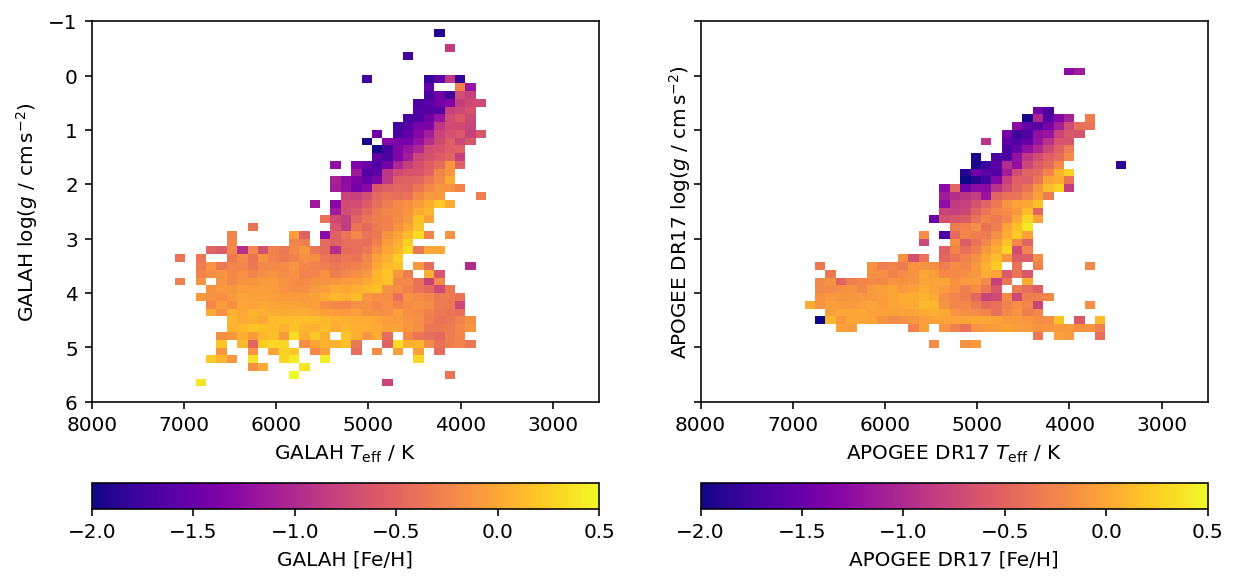

In [8]:
def plot_hrd_colored_by_median_feh():

    f, gs = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)

    teff_limits = (2500,8000)
    logg_limits = (-1,6)

    use = (
        (joined['flag_sp'] == 0) &
        np.isfinite(joined['FE_H'])
    )

    kwargs = dict(
        bins = (np.linspace(teff_limits[0],teff_limits[1],50),np.linspace(logg_limits[0],logg_limits[1],50)),
        cmap='plasma',
        minimum_bin_entries=1,
        colorbar_orientation='horizontal',
        vmin=-2.0,vmax=0.5)

    # GALAH
    ax = gs[0]
    ax.set_xlim(teff_limits[1],teff_limits[0])
    ax.set_ylim(logg_limits[1],logg_limits[0])

    hist2d_bin_colored(
        X = joined['teff'][use],
        Y = joined['logg'][use],
        Z = joined['fe_h'][use],
        X_label = r'GALAH $T_\mathrm{eff}~/~\mathrm{K}$',
        Y_label = r'GALAH $\log (g~/~\mathrm{cm\,s^{-2}})$',
        Z_label = r'GALAH [Fe/H]',
        ax = ax,**kwargs
    )

    # APOGEE DR17
    ax = gs[1]
    hist2d_bin_colored(
        X = joined['TEFF'][use],
        Y = joined['LOGG'][use],
        Z = joined['FE_H'][use],
        X_label = r'APOGEE DR17 $T_\mathrm{eff}~/~\mathrm{K}$',
        Y_label = r'APOGEE DR17 $\log (g~/~\mathrm{cm\,s^{-2}})$',
        Z_label = r'APOGEE DR17 [Fe/H]',
        ax = ax,**kwargs
    )

plot_hrd_colored_by_median_feh()

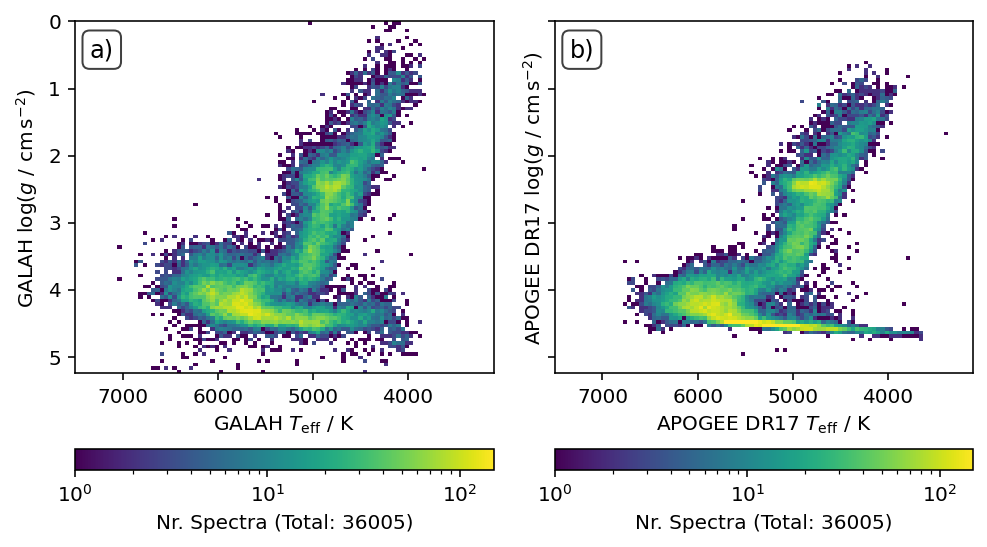

In [9]:
def plot_hrd_colored_by_density():

    f, gs = plt.subplots(1,2,figsize=(7,4),sharex=True,sharey=True)

    teff_limits = (3100,7500)
    logg_limits = (0,5.25)

    use = (
        (joined['flag_sp'] == 0) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined['FE_H'])
    )

    kwargs = dict(
        bins = (np.linspace(teff_limits[0],teff_limits[1],100),np.linspace(logg_limits[0],logg_limits[1],100)),
        cmap='viridis',
        cmin=1,
        norm=LogNorm(vmin=1,vmax=150),
    )

    # GALAH
    ax = gs[0]
    ax.text(0.035,0.9,'a)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'GALAH $T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel(r'GALAH $\log (g~/~\mathrm{cm\,s^{-2}})$')
    
    h = ax.hist2d(
        joined['teff'][use],
        joined['logg'][use],
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['teff'][use]))+')')

    # Gaia DR3 Photometry
    ax = gs[1]
    ax.text(0.035,0.9,'b)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'APOGEE DR17 $T_\mathrm{eff}~/~\mathrm{K}$')
    ax.set_ylabel(r'APOGEE DR17 $\log (g~/~\mathrm{cm\,s^{-2}})$')

    h = ax.hist2d(
        joined['TEFF'][use],
        joined['LOGG'][use],
        **kwargs
    )
    c = plt.colorbar(h[-1],ax=ax,orientation='horizontal')
    c.set_label('Nr. Spectra (Total: '+str(len(joined['teff'][use]))+')')

    ax.set_xlim(teff_limits[1],teff_limits[0])
    ax.set_ylim(logg_limits[1],logg_limits[0])
    
    plt.tight_layout()
    plt.savefig('figures/galah_dr4_validation_apogeedr17_hrd_density.png',dpi=200,bbox_inches='tight')

plot_hrd_colored_by_density()

In [36]:
def plot_comparison_stellar_parameters(joined, subset = 'all', name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,3,figsize=(10,3))
    
    if subset == 'all':
        subset_cuts = np.isfinite(joined['teff'])
    elif subset == 'giants':
        subset_cuts = (
            (joined['teff'] < 5500) & 
            (joined['logg'] < 4.0) &
            (joined['logg'] < 3.75 - (joined['teff']-5000)/1000.) & 
            (joined['logg'] < 5 + (joined['teff']-5200)/400.)
        )
    elif subset == 'dwarfs':
        subset_cuts = (
            (joined['teff'] >= 5500) | 
            (joined['logg'] >= 4.0) |
            (joined['logg'] >= 3.75 - (joined['teff']-5000)/1000.) |
            (joined['logg'] >= 5 + (joined['teff']-5200)/400.)
        )
        
    apply_quality_cuts = (
        subset_cuts & 
        np.isfinite(joined['teff']) &
        np.isfinite(joined[common_keys['teff']]) &
        np.isfinite(joined['logg']) &
        np.isfinite(joined[common_keys['logg']]) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[common_keys['fe_h']])
    )
    
    # First panel: Teff
    ax = gs[0]
    ax.text(0.05,0.9,'a)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'Teff / K ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$Teff / K (Lit. - DR4)')
    ax.hist2d(
        joined[common_keys['teff']][apply_quality_cuts],
        joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],
        bins=(np.linspace(3500,6500,100),np.linspace(-500,500,100)),
        cmin=1,norm=LogNorm()
    )
    percentiles = np.percentile(joined[common_keys['teff']][apply_quality_cuts]-joined['teff'][apply_quality_cuts],q=[16,50,84])
    text = r'$\Delta T_\mathrm{eff} = {'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
    ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # Second panel: logg
    ax = gs[1]
    ax.text(0.05,0.9,'b)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'log (g / cm s-2) ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$log (g / cm s-2) (Lit. - DR4)')
    ax.hist2d(
        joined[common_keys['logg']][apply_quality_cuts],
        joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],
        bins=(np.linspace(-1,5.5,100),np.linspace(-1,1,100)),
        cmin=1,norm=LogNorm()
    )
    percentiles = np.percentile(joined[common_keys['logg']][apply_quality_cuts]-joined['logg'][apply_quality_cuts],q=[16,50,84])
    text = r'$\Delta \log g = {'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
    ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    # First panel: [Fe/H]
    ax = gs[2]
    ax.text(0.05,0.9,'c)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'[Fe/H] ('+name_literature+')')
    ax.set_ylabel(r'$\Delta$[Fe/H] (Lit. - DR4)')
    ax.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],
        bins=(np.linspace(-3,1,100),np.linspace(-0.5,0.5,100)),
        cmin=1,norm=LogNorm()
    )
    percentiles = np.percentile(joined[common_keys['fe_h']][apply_quality_cuts]-joined['fe_h'][apply_quality_cuts],q=[16,50,84])
    text = r'$\Delta \mathrm{[Fe/H]} = {'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
    ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))
    ax.axhline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()
    plt.savefig('figures/galah_dr4_validation_apogeedr17_teffloggfeh_diff_'+subset+'.png',dpi=200,bbox_inches='tight')

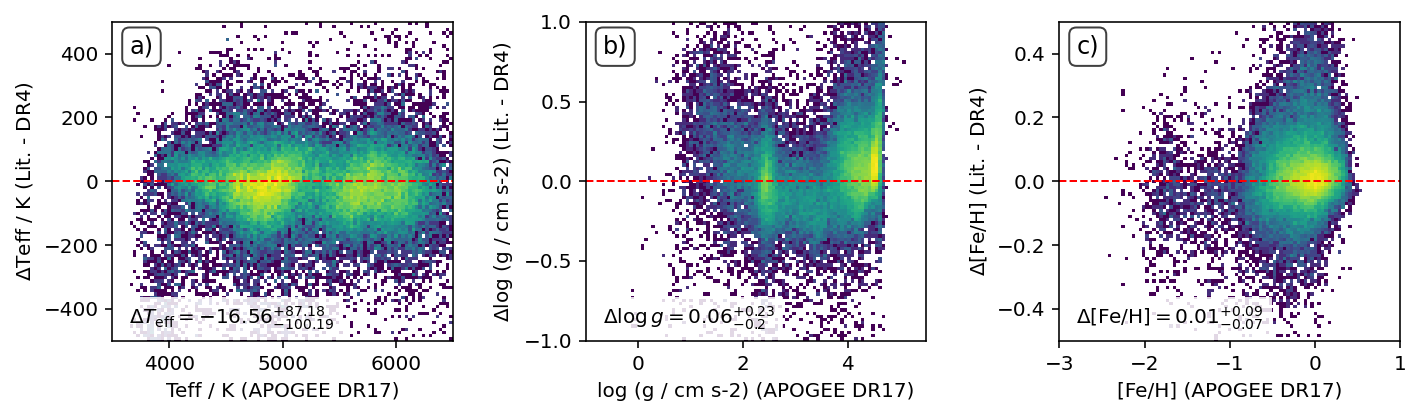

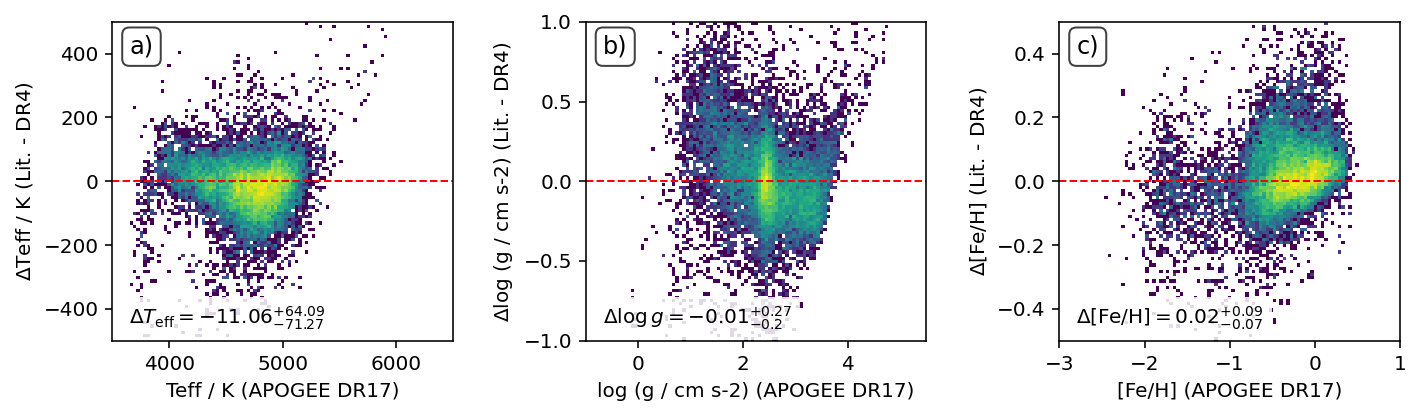

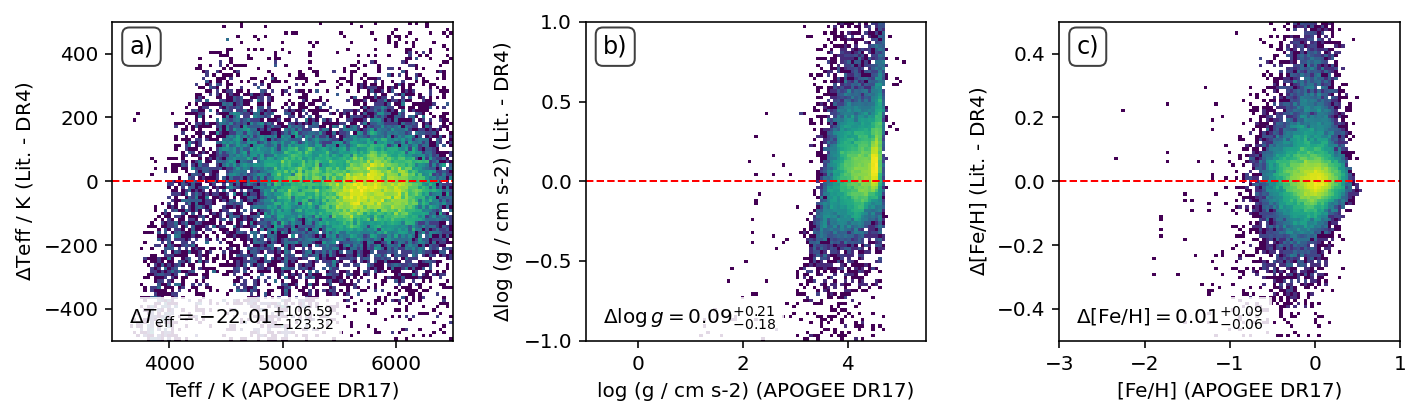

In [37]:
plot_comparison_stellar_parameters(joined,subset='all')
plot_comparison_stellar_parameters(joined,subset='giants')
plot_comparison_stellar_parameters(joined,subset='dwarfs')

In [51]:
joined.keys()

['sobject_id',
 'tmass_id',
 'gaiadr3_source_id',
 'flag_sp',
 'chi2_sp',
 'model_name',
 'teff',
 'e_teff',
 'logg',
 'e_logg',
 'fe_h',
 'e_fe_h',
 'flag_fe_h',
 'vmic',
 'e_vmic',
 'vsini',
 'e_vsini',
 'li_fe',
 'e_li_fe',
 'flag_li_fe',
 'c_fe',
 'e_c_fe',
 'flag_c_fe',
 'n_fe',
 'e_n_fe',
 'flag_n_fe',
 'o_fe',
 'e_o_fe',
 'flag_o_fe',
 'na_fe',
 'e_na_fe',
 'flag_na_fe',
 'mg_fe',
 'e_mg_fe',
 'flag_mg_fe',
 'al_fe',
 'e_al_fe',
 'flag_al_fe',
 'si_fe',
 'e_si_fe',
 'flag_si_fe',
 'k_fe',
 'e_k_fe',
 'flag_k_fe',
 'ca_fe',
 'e_ca_fe',
 'flag_ca_fe',
 'sc_fe',
 'e_sc_fe',
 'flag_sc_fe',
 'ti_fe',
 'e_ti_fe',
 'flag_ti_fe',
 'v_fe',
 'e_v_fe',
 'flag_v_fe',
 'cr_fe',
 'e_cr_fe',
 'flag_cr_fe',
 'mn_fe',
 'e_mn_fe',
 'flag_mn_fe',
 'co_fe',
 'e_co_fe',
 'flag_co_fe',
 'ni_fe',
 'e_ni_fe',
 'flag_ni_fe',
 'cu_fe',
 'e_cu_fe',
 'flag_cu_fe',
 'zn_fe',
 'e_zn_fe',
 'flag_zn_fe',
 'rb_fe',
 'e_rb_fe',
 'flag_rb_fe',
 'sr_fe',
 'e_sr_fe',
 'flag_sr_fe',
 'y_fe',
 'e_y_fe',
 'flag_y_fe',

In [65]:
element = 'Al'

apply_quality_cuts = (
        (joined['flag_'+element.lower()+'_fe'] == 0) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[element.lower()+'_fe']) &
        np.isfinite(joined[common_keys['fe_h']]) &
        np.isfinite(joined[common_keys[element.lower()+'_fe']])
    )

print(
    "{:.3f}".format(np.nanmedian(joined['e_'+element.lower()+'_fe'][apply_quality_cuts])),
    "{:.3f}".format(np.nanmedian(joined[element.upper()+'_FE_ERR'][apply_quality_cuts])),
    "{:.3f}".format(np.sqrt(
    np.nanmedian(joined['e_'+element.lower()+'_fe'][apply_quality_cuts])**2+
    np.nanmedian(joined[element.upper()+'_FE_ERR'][apply_quality_cuts])**2
    ))
)

0.027 0.021 0.035


In [43]:
def plot_comparison_xfe(joined, element = 'C', name_literature = 'APOGEE DR17'):
    f, gs = plt.subplots(1,3,figsize=(10,3),sharey=True)
    
    apply_quality_cuts = (
        (joined['flag_'+element.lower()+'_fe'] == 0) &
        np.isfinite(joined['fe_h']) &
        np.isfinite(joined[element.lower()+'_fe']) &
        np.isfinite(joined[common_keys['fe_h']]) &
        np.isfinite(joined[common_keys[element.lower()+'_fe']])
    )
    
    xbins = np.linspace(-2.5,0.75,100)
    if element == 'Li':
        ybins = np.linspace(-2,4,100)
    elif element in ['O','Ba','Y']:
        ybins = np.linspace(-2,2,100)
    else:
        ybins = np.linspace(-1,1,100)
    
    # First panel: GALAH DR4 [Fe/H] vs. [X/Fe]
    ax = gs[0]
    ax.text(0.05,0.9,'a)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel('[Fe/H] (GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] (GALAH DR4)')
    ax.hist2d(
        joined['fe_h'][apply_quality_cuts],
        joined[element.lower()+'_fe'][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Second panel: Literature [Fe/H] vs. [X/Fe]
    ax = gs[1]
    ax.text(0.05,0.9,'b)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel('[Fe/H] ('+name_literature+')')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys['fe_h']][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (xbins,ybins),cmin=1,norm=LogNorm()
    )
    ax.set_xlim(
        np.min([
            np.min(joined['fe_h'][apply_quality_cuts])-0.1,
            np.min(joined[common_keys['fe_h']][apply_quality_cuts])-0.1
        ]),
        np.max([
            np.max(joined['fe_h'][apply_quality_cuts])+0.1,
            np.max(joined[common_keys['fe_h']][apply_quality_cuts])+0.1
        ]),
    )
    
    # Third panel: Difference [X/Fe]
    ax = gs[2]
    ax.text(0.05,0.9,'c)',transform=ax.transAxes,fontsize=12,bbox=dict(boxstyle='round', facecolor='w', alpha=0.75))
    ax.set_xlabel(r'$\Delta$['+element+'/Fe] ('+name_literature+' - GALAH DR4)')
    ax.set_ylabel('['+element+'/Fe] ('+name_literature+')')
    ax.hist2d(
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],
        joined[common_keys[element.lower()+'_fe']][apply_quality_cuts],
        bins = (np.linspace(-0.5,0.5,100),ybins),cmin=1,norm=LogNorm()
    )
    
    percentiles = np.percentile(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts],q=[16,50,84])
    mean = np.mean(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts])
    sigma = np.std(joined[common_keys[element.lower()+'_fe']][apply_quality_cuts]-joined[element.lower()+'_fe'][apply_quality_cuts])
    text = r'$\Delta$['+element+'/Fe] $={'+str(np.round(percentiles[1],decimals=2))+'}_{-'+str(np.round(percentiles[1]-percentiles[0],decimals=2))+'}^{+'+str(np.round(percentiles[2]-percentiles[1],decimals=2))+'}$'
    ax.text(0.05,0.05,text,transform=ax.transAxes,bbox=dict(lw=0, facecolor='w', alpha=0.85))

    apply_quality_cuts_solar = (
        apply_quality_cuts &
        (joined[common_keys[element.lower()+'_fe']] > -0.25)& 
        (joined[common_keys[element.lower()+'_fe']] < 0.25)
    )
    ax.axvline(0,c='r',lw=1,ls='dashed')
    
    plt.tight_layout()
    plt.savefig('figures/galah_dr4_validation_apogeedr17_'+element.lower()+'_fe_density.png',dpi=200,bbox_inches='tight')

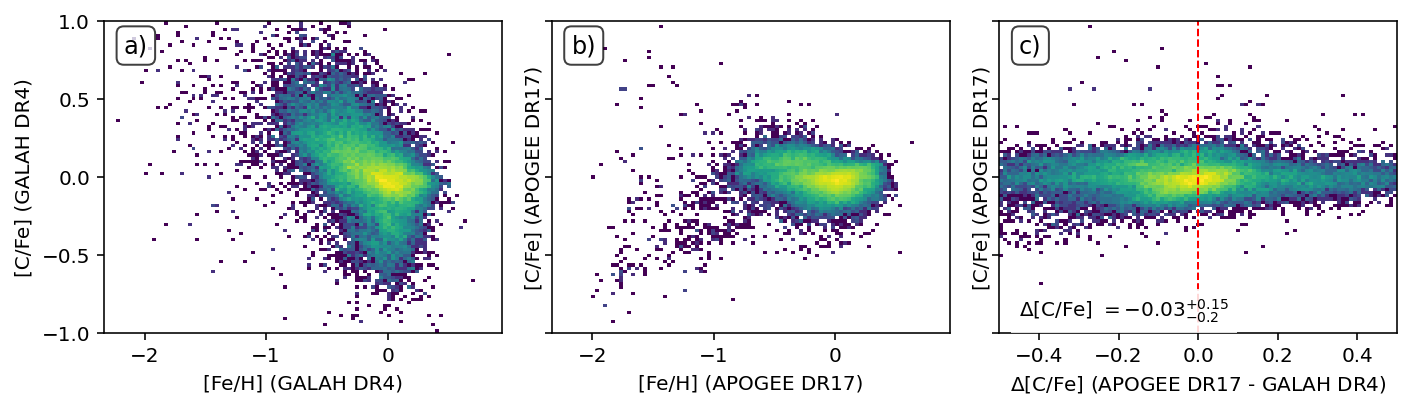

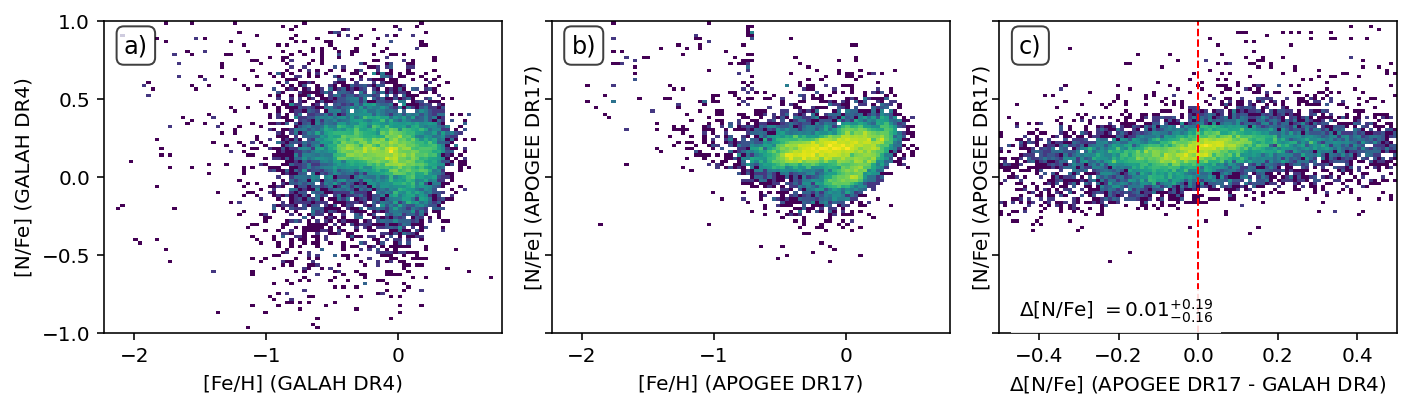

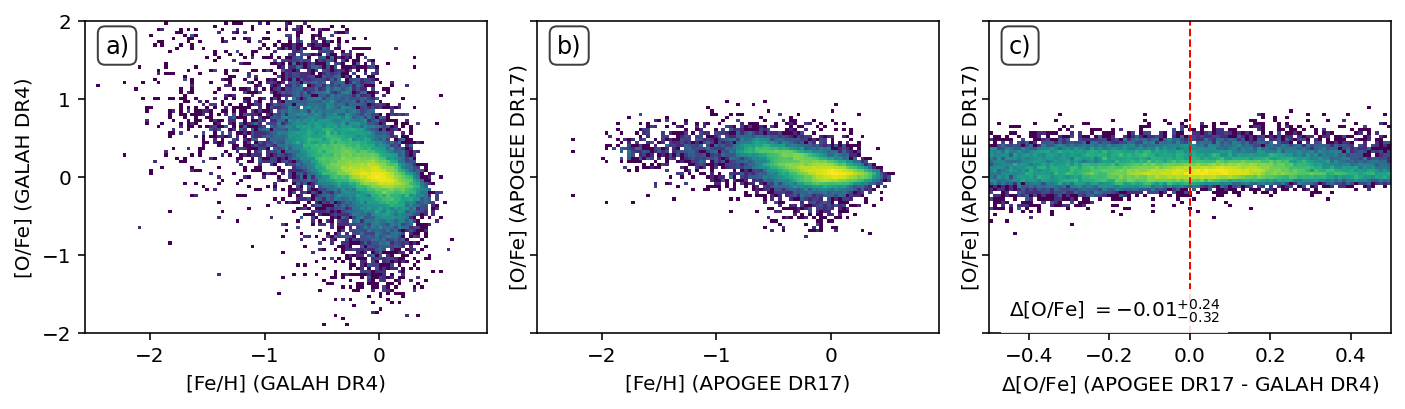

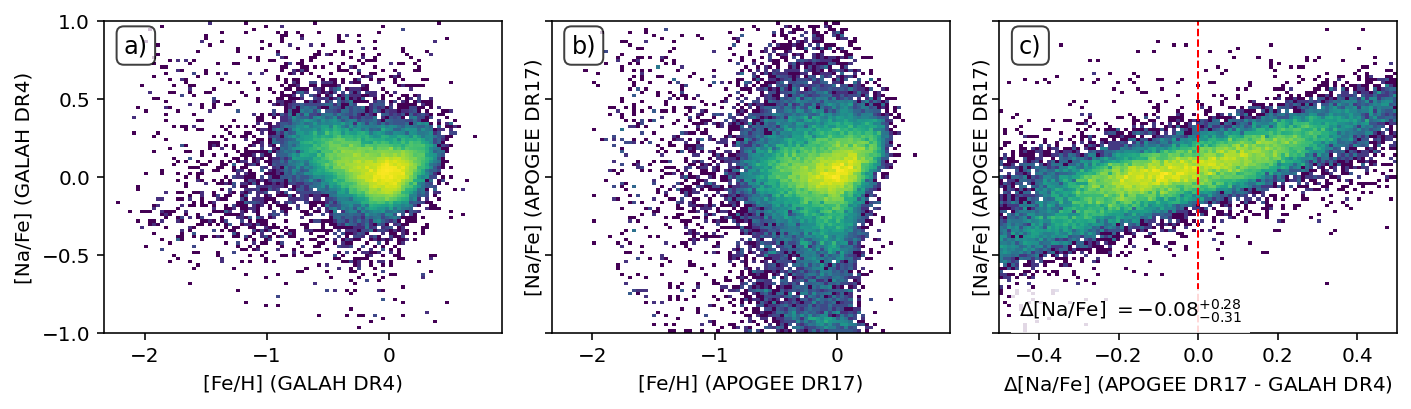

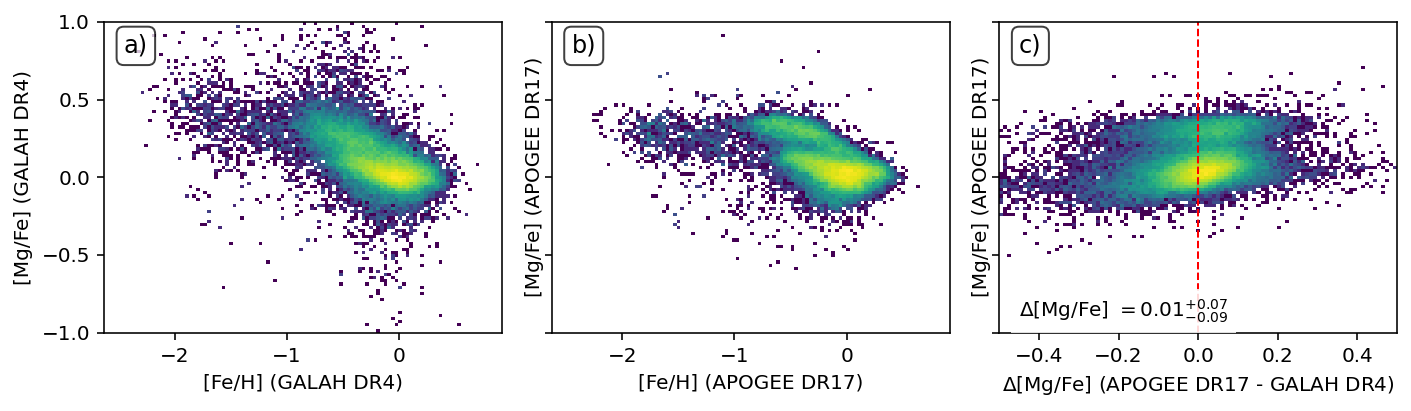

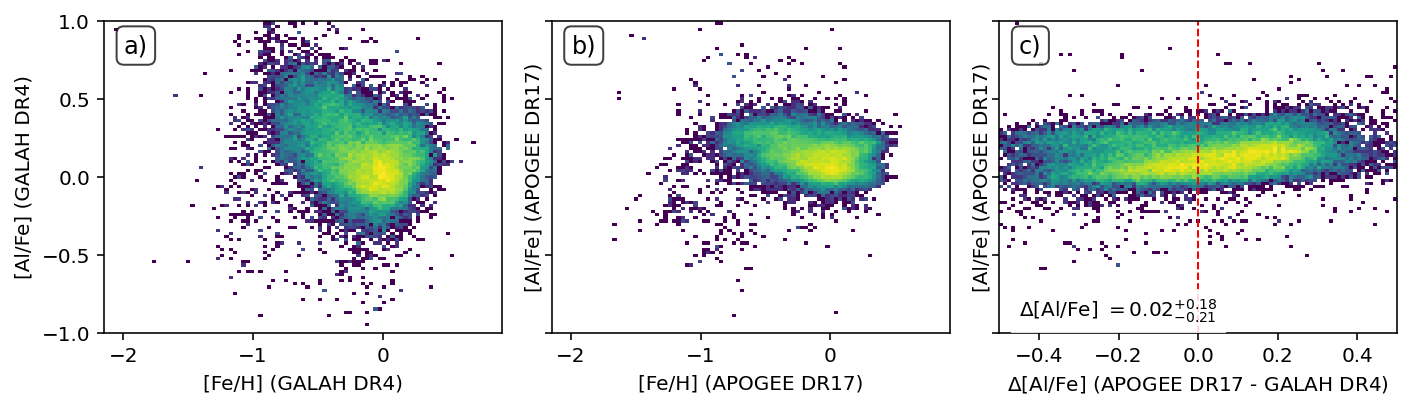

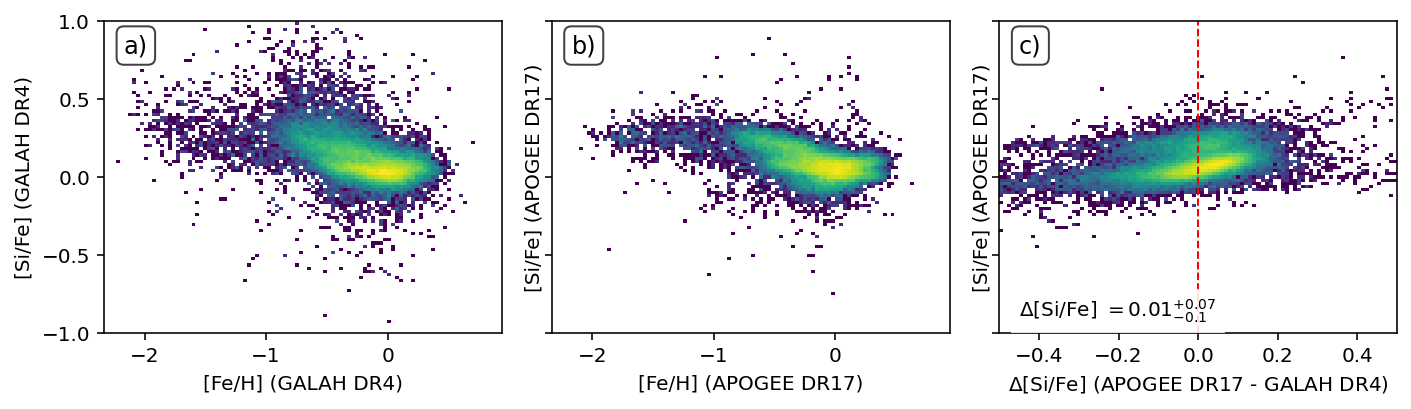

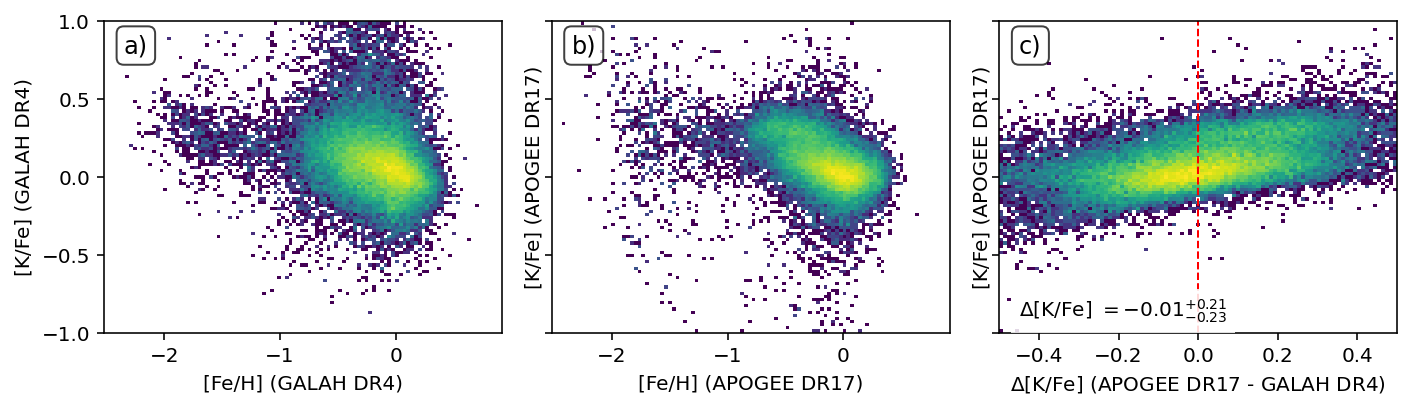

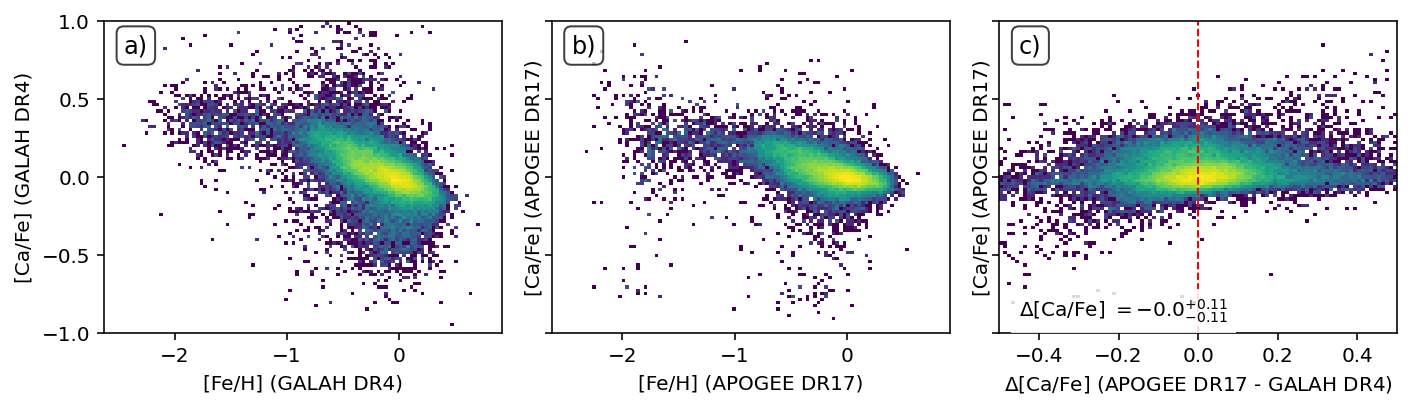

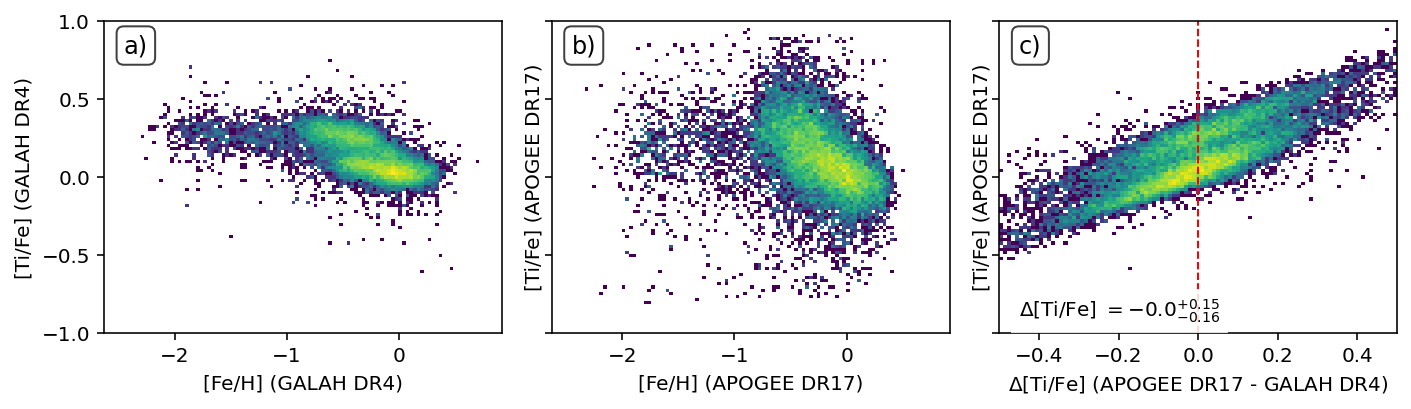

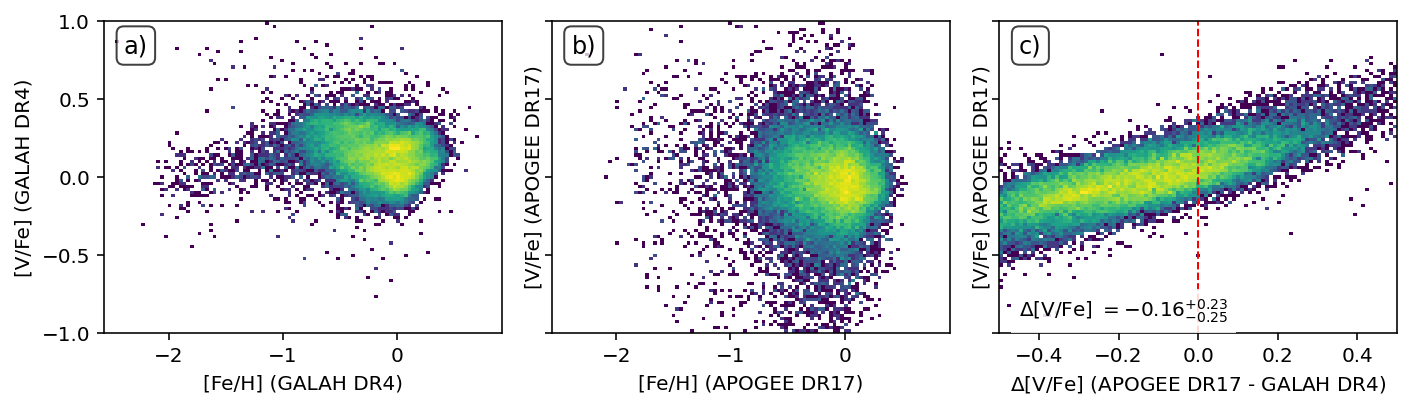

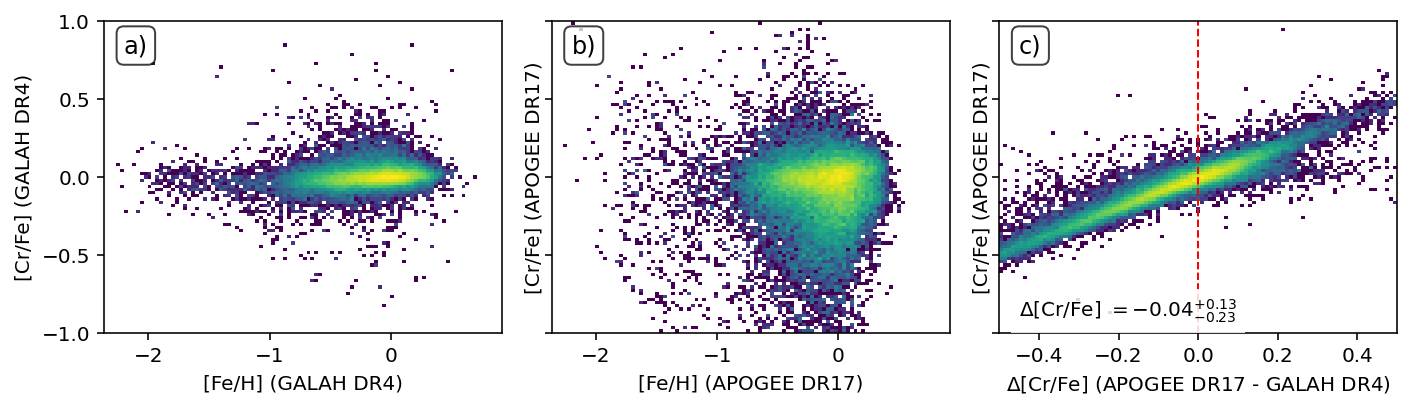

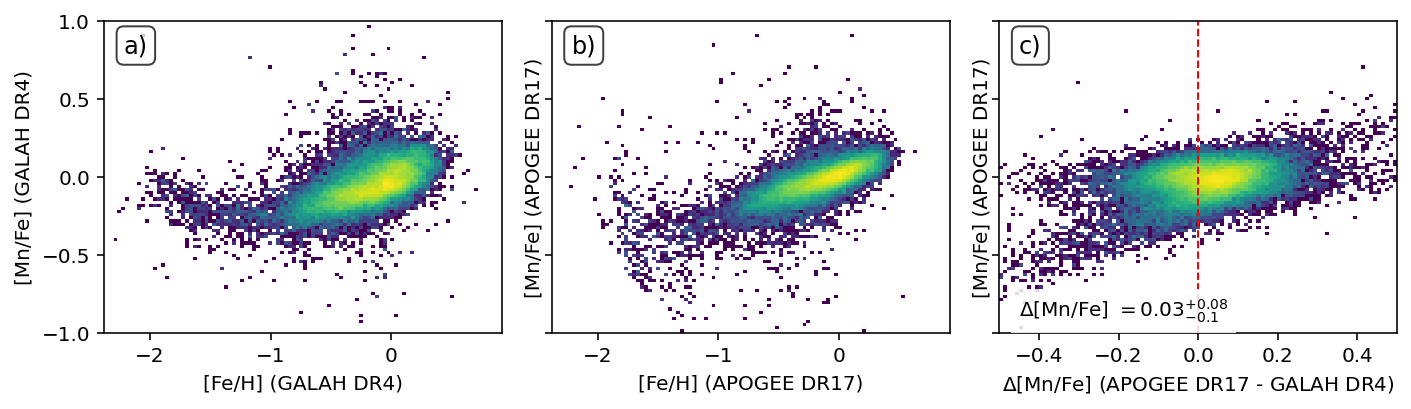

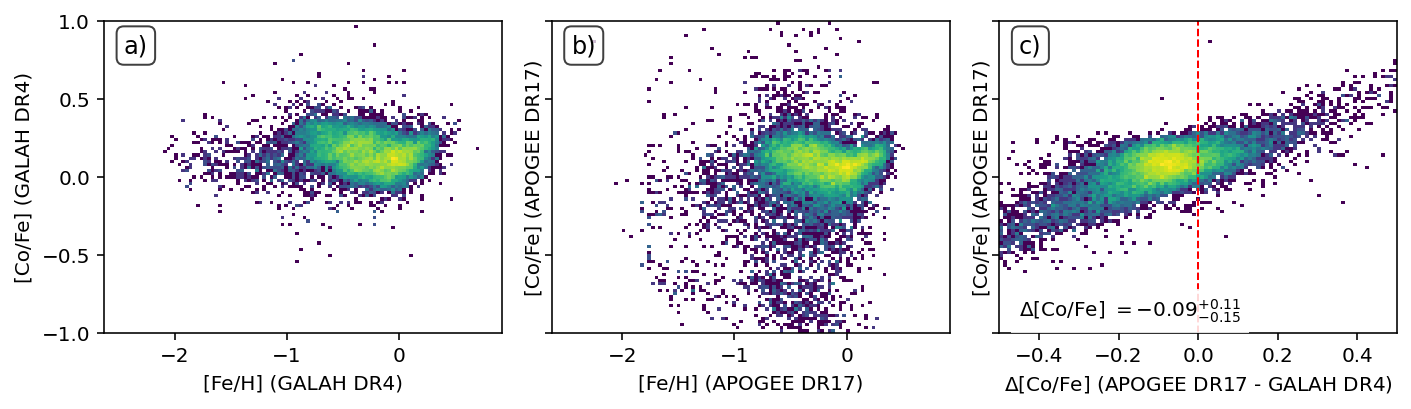

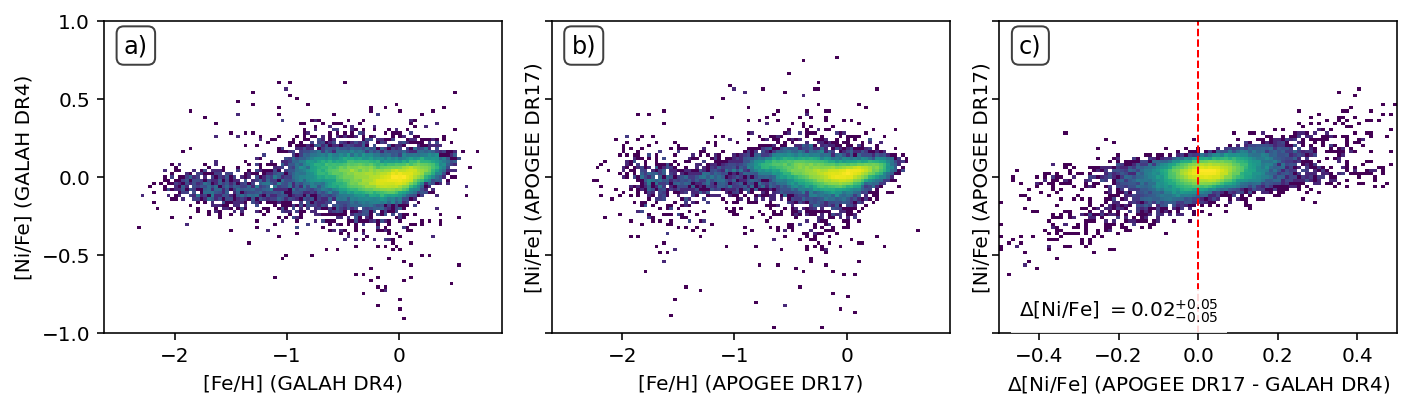

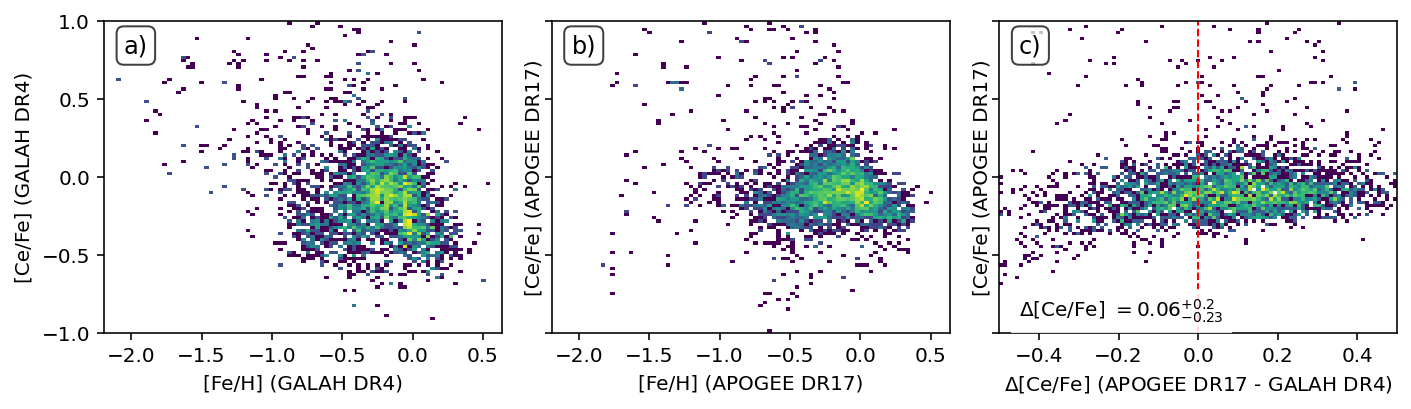

In [44]:
for element in ['C','N','O','Na','Mg','Al','Si','K','Ca','Ti','V','Cr','Mn','Co','Ni','Ce']:
    plot_comparison_xfe(joined, element = element)